In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

#model related
import torch
import torchvision.models as models
from PIL import Image
import seaborn as sns

#statistical test and ploting: 
import time
import pickle

from itertools import combinations
from torch.nn import CosineSimilarity

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from help_functions import rename_images,run_sim_on_all_possible_pairs , create_image_matches_dataframe , process_and_extract_activations_from_folder, compare_image_similarity_pickled_features

In [3]:
# This is the name of the dataset of imges used , found in the relative project folder in the directory 
project_name = 'fungi'

#similarity df related properties: 
model = models.vgg16(pretrained=True,dropout=0) #define the model
model_name=model._get_name()

selected_nodes=['features.4','features.9','features.16','features.23','features.30','classifier.1','classifier.4']
selected_dictionary={node:'level_'+str(i) for i,node in enumerate(selected_nodes)}
create_similarity_df=False


c:\Users\User\Desktop\visual_memory_project\visual-memory-project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\Desktop\visual_memory_project\visual-memory-project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: unexpected EOF, expected 279287212 more bytes. The file might be corrupted.

In [1]:
model

NameError: name 'model' is not defined

In [25]:
#temporary test: take the birds images that are currently seperated into categories, and within each category images are named
#numericaly from 1 - 5, change it into a single directory with images names relfecting the subdirectory they came from + thier number: 
to_rename_images=False
PATH_TO_PROJECT=Path.cwd().parent.parent / 'projects' / project_name 

folder_name_before_renaming='birds dataset validation set'
folder_name_after_renaming='raw data'

if to_rename_images: 
    print('renaming images')
    #enter the name of the non renamed data and the new name of the renamed data set (preferably :"raw data")
    rename_images(folder_name_before_renaming, folder_name_after_renaming,img_type = '.jpg')      

In [28]:
#this section assumes standartization - meaning that each relevant project has the same name for the 3 subfolders: 
PATH_TO_RAW_DATA=Path.cwd().parent.parent / 'projects' / project_name / 'raw data'
PATH_TO_PROCESSED_DATA=PATH_TO_RAW_DATA.parent /  Path(PATH_TO_RAW_DATA.name + '_processed_'+ model_name)
PATH_TO_ACTIVATIONS_DATA=PATH_TO_RAW_DATA.parent /  Path(PATH_TO_RAW_DATA.name + '_features_'+ model_name)

PATHS_TO_EACH_RAW_IMG = list(PATH_TO_RAW_DATA.iterdir())

print('data locations:')
print('original images locatoin:\n',PATH_TO_RAW_DATA)
print('original processed (scaled and mean transformed) locatoin:\n',PATH_TO_PROCESSED_DATA)
print('original activations locatoin:\n',PATH_TO_ACTIVATIONS_DATA)

data locations:
original images locatoin:
 c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual memory project\projects\fungi\raw data
original processed (scaled and mean transformed) locatoin:
 c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual memory project\projects\fungi\raw data_processed_VGG
original activations locatoin:
 c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual memory project\projects\fungi\raw data_features_VGG


In [40]:
#take note that this code takes around 50 minutes to run (on 2250 images) - so if you dont need it (because you allready extracted activations, try to avoid it)
to_extract=False
if to_extract:
    print('processing and extracting activations')
    images_info,informative_nodes,informative_nodes_original = process_and_extract_activations_from_folder(PATH_TO_RAW_DATA,PATH_TO_RAW_DATA.parent,model,features_dict=selected_dictionary, images_type = 'jpg')
else:
    print('loading images info and informative nodes dictionary')
    images_info=pd.read_csv(PATH_TO_PROJECT/f'images_info_{project_name}.csv')
    images_info['sub_folder']=images_info['sub_folder'].fillna('')
    informative_nodes=pd.read_pickle(PATH_TO_PROJECT/'informative_nodes.pickle')
    informative_nodes_original=pd.read_pickle(PATH_TO_PROJECT/'informative_nodes.pickle')


processing and extracting activations
creating a new folder: c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual memory project\projects\birds\raw data_processed_VGG
extracting VGG features


In [41]:
def run_sim_on_all_possible_pairs_with_range(FULL_PATH_PARENT_FOLDER,images_info_df,return_nodes_dict,model,iter_range=[]):

    model_name = model._get_name()
    model_features_folder_name = FULL_PATH_PARENT_FOLDER.name +'_features_' + model_name

    similarity_df=pd.DataFrame()
    all_pairs_length=len(list(combinations(images_info_df['img_name'].values,2)))
    if len(iter_range)==0:
        all_pairs=combinations(images_info_df['img_name'].values,2)
    elif len(iter_range)==2:
        all_pairs=list(combinations(images_info_df['img_name'].values,2))[iter_range[0]:iter_range[1]]
    else:
        raise Exception('iter_range should be a list of 2 values (left one is smaller)')


    cat1_tot = []
    cat2_tot = []

    for i,(im1_name,im2_name) in enumerate(all_pairs): 
        #estimate run time: 
        if i==0:
            start=time.time()

        cat1 = images_info_df[images_info_df['img_name'] == im1_name].iloc[0]['sub_folder']
        cat2 = images_info_df[images_info_df['img_name'] == im2_name].iloc[0]['sub_folder']

        cat1_tot.append(cat1)
        cat2_tot.append(cat2)

        distances,_=compare_image_similarity_pickled_features(FULL_PATH_PARENT_FOLDER,model_features_folder_name,im1_name.replace('.jpg','.pkl'),im2_name.replace('.jpg','.pkl'),cat1,cat2,CosineSimilarity(0))
        pair_line=pd.DataFrame(columns=['image1','image2']+list(return_nodes_dict.values()),index=[i])
        pair_line[['image1','image2','model']]=im1_name.replace('.jpg','.pkl'),im2_name.replace('.jpg','.pkl'),model_name
        pair_line[[colname for colname in pair_line.columns if colname in return_nodes_dict.values()]]=distances
        similarity_df=pd.concat([similarity_df,pair_line],axis=0)
        
        if i==0: 
            end=time.time()
            elapsed=end-start
            print(f'estimated time: first sample took {elapsed:.3f}, all pairs: {all_pairs_length} is estimated to take {elapsed*all_pairs_length/60:.3f} minutes')

        if np.mod(i,500)==0 and not(i==0):
            print(' iteration #', i)
    
    """if len( list(zip(cat1_tot,cat2_tot)))==0:
        similarity_df[['category1', 'category2']]=["",""]
    else:"""
    
    similarity_df[['category1', 'category2']] = list(zip(cat1_tot,cat2_tot))
        
    file_name = 'similarity_between_pairs_' + model_name + '_.csv'
    similarity_df.to_csv(file_name,index=False)    

    return similarity_df

In [30]:

steps_before_saving=50000
start_from_enum_index=0 #should be 0 if starting fresh, or the iteration number that crashed (the index of the latest csv that is not full according to the step size)

PATH_TO_SEPERATED_CSVS=PATH_TO_PROJECT / 'seperated_similarity_csvs'
if not (PATH_TO_SEPERATED_CSVS).exists():
    print('created a folder to hold the seperated csvs')
    Path.mkdir(PATH_TO_SEPERATED_CSVS)

if create_similarity_df:
    # _features_VGG is added by "run_sim_on_all..."
    all_pairs=list(combinations(images_info['img_name'].values,2))
    all_timings=[]

    print('saving seperated files in:\n',PATH_TO_SEPERATED_CSVS)

    for i,ind in enumerate(np.arange(0,len(all_pairs),steps_before_saving)):
        if i>=start_from_enum_index:
            print('starting iteration index',i,ind)
            start=time.perf_counter()
            iter_range=[ind,min(ind+steps_before_saving,len(all_pairs))]
            temp_similarity_df = run_sim_on_all_possible_pairs_with_range(PATH_TO_RAW_DATA,images_info.copy(),informative_nodes,model,iter_range)
            temp_similarity_df.to_csv(PATH_TO_SEPERATED_CSVS / f'similarity_{project_name}_{i}.csv',index=False )
            all_timings.append(time.perf_counter()-start)
            print(all_timings)
            print('finished iteration index',i,ind)
        else:
            print(f'skipping iteration index {i}')


now read all the similarity csvs that were broken into 15000 rows pieces into a single "similarity_df" dataframe

In [31]:
#change to have the path where the seperated csvs were saved:
to_merge=False
if to_merge: 
    all_csvs=[file for file in PATH_TO_SEPERATED_CSVS.iterdir() if not 'all' in file.name]
    #load csvs into a single large matrix: 
    similarity_df=pd.DataFrame()
    for curr_csv in all_csvs:
        print('loading ',curr_csv)
        curr_df=pd.read_csv(curr_csv)
        similarity_df=pd.concat([similarity_df,curr_df])
        
    print('similarity_df was saved')
    similarity_df.to_csv(PATH_TO_PROJECT / f'similarity_{project_name}_all_{model_name}.csv')

In [32]:
to_load=True
if to_load:
    print('similarity_df was loaded')
    similarity_df=pd.read_csv(PATH_TO_PROJECT / f'similarity_{project_name}_all_{model_name}.csv')


similarity_df was loaded


<AxesSubplot:>

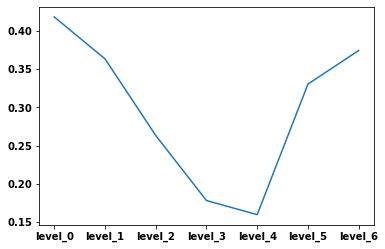

In [33]:
similarity_df[[col for col in similarity_df.columns if 'level' in col]].mean().plot()

          level_0   level_1   level_2   level_3   level_4   level_5   level_6
level_0  1.000000  0.830802  0.599125  0.408488  0.259202  0.203596  0.200848
level_1  0.830802  1.000000  0.821979  0.526508  0.287945  0.252705  0.244586
level_2  0.599125  0.821979  1.000000  0.764327  0.415505  0.402346  0.358849
level_3  0.408488  0.526508  0.764327  1.000000  0.654242  0.551802  0.467043
level_4  0.259202  0.287945  0.415505  0.654242  1.000000  0.768035  0.711535
level_5  0.203596  0.252705  0.402346  0.551802  0.768035  1.000000  0.920621
level_6  0.200848  0.244586  0.358849  0.467043  0.711535  0.920621  1.000000


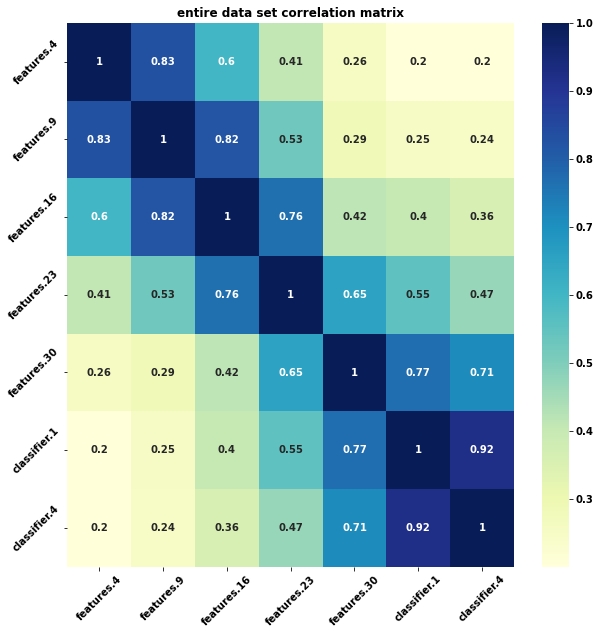

In [34]:
# import modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
  
sim_level_colnames=[colname for colname in similarity_df.columns if 'level' in colname]
print(similarity_df[sim_level_colnames].corr())
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(10,10))
dataplot = sns.heatmap(similarity_df[sim_level_colnames].corr(), cmap="YlGnBu", annot=True,ax=axes)
# displaying heatmap
axes.set_title('entire data set correlation matrix')
axes.set_xticks(ticks=axes.get_xticks(),labels=selected_nodes,rotation=45)
axes.set_yticks(ticks=axes.get_yticks(),labels=selected_nodes,rotation=45)
plt.show()

fig.savefig(PATH_TO_PROJECT / 'data_set_extracted_layer_correlation_matrix.svg')

